# Problem: Predicting Airplane Delays

The goals of this notebook are:

- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario

You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US.

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset

The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).


# Step 1: Prepare the environment

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:

1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.


# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:

1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.


# Machine Learning on AWS Cloud

## Combined Data version 1


In [ ]:
# import libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Setting up S3 bucket


In [ ]:
import logging


# import boto3


from botocore.exceptions import ClientError


def create_bucket(bucket_name, region=None):
    # Create an S3 bucket in a specified region
    # If a region is not specified, the bucket is created in the S3 default
    # region (us-east-1).
    # :param bucket_name: Bucket to create
    # :param region: String region to create bucket in, e.g., 'us-west-2'
    # :return: True if bucket created, else False

    # Create bucket

    try:

        if region is None:

            s3_client = boto3.client("s3")

            s3_client.create_bucket(Bucket=bucket_name)
        else:

            s3_client = boto3.client("s3", region_name=region)

            location = {"LocationConstraint": region}

            s3_client.create_bucket(
                Bucket=bucket_name, CreateBucketConfiguration=location
            )

    except ClientError as e:

        logging.error(e)

        return False

    print(f"S3 Bucket: {bucket_name} created successfully")

    return True

In [ ]:
# Function to check if the bucket exists
def check_bucket_exists(bucket_name):
    s3 = boto3.client("s3")
    try:
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        # If a 404 error is raised, the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            # If there's any other error, raise it
            raise

In [ ]:
# set the s3 bucket name
bucket = "u3253992-ajulthomas-oncloud"

# fetch the s3 resource
s3_resource = boto3.Session().resource("s3")


# check if bucket exists
bucket_exists = check_bucket_exists(bucket)

# Create the bucket if it doesn't exist
if not bucket_exists:
    create_bucket(bucket)

Bucket 'u3253992-ajulthomas-oncloud' already exists.


In [ ]:
# setting the prefix
prefix = "oncloud"


# uploading data to aws s3
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_resource.Bucket(bucket))
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

### Generic Functions


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# function to plot confusion matrix
def plot_confusion_matrix(test_labels, target_predicted):
    # complete the code here
    cm = confusion_matrix(test_labels, target_predicted)
    # Create a heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["On-Time", "Delayed"],
        yticklabels=["On-Time", "Delayed"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

### Loading Data


In [ ]:
import pandas as pd

# load the data


data_v1 = pd.read_csv("./combined_csv_v1.csv")


data_v1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# shape of the data
data_v1.shape

(1635590, 75)

## Model 1 - Linear Learner

---


In [ ]:
# create a copt of the version 1 data

df = data_v1.copy()

df.shape

(1635590, 75)

In [ ]:
df_cleaned = df.replace({True: 1, False: 0})

df_cleaned.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_cleaned.isnull().sum().sum()

0

In [ ]:
df_cleaned.shape

(1635590, 75)

In [ ]:
# split the data

train, test_and_validate = train_test_split(
    df_cleaned, test_size=0.3, random_state=42, stratify=df_cleaned["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [ ]:
# shape of train data
train.shape

(1144913, 75)

In [ ]:
# shape of test
test.shape

(245338, 75)

In [ ]:
# shape of validate
validate.shape

(245339, 75)

In [ ]:
# set the names of the csv files
train_file = "data_v1_train.csv"
test_file = "data_v1_test.csv"
validate_file = "data_v1_validate.csv"

### Upload data to S3 Bucket


In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac


# prepare data for sagemaker training


def prepare_data(dataframe):
    vectors = dataframe.drop(columns=["target"]).values.astype("float32")
    labels = dataframe["target"].values.astype("float32")
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, vectors, labels)
    buf.seek(0)

    return buf

In [ ]:
import boto3
import os


# upload training data to s3
def upload_s3_buf(buf, bucket, prefix, type):
    key = "recordio-pb-data"
    boto3.resource("s3").Bucket(bucket).Object(
        os.path.join(prefix, type, key)
    ).upload_fileobj(buf)
    s3_data_path = "s3://{}/{}/{}/{}".format(bucket, prefix, type, key)
    print("uploaded {} data to location: {}".format(type, s3_data_path))
    return s3_data_path

In [ ]:
# prepare train data
train_buf = prepare_data(train)

# upload train data
s3_train_data = upload_s3_buf(train_buf, bucket, prefix, "train")

uploaded train data to location: s3://u3253992-ajulthomas-oncloud/oncloud/train/recordio-pb-data


In [ ]:
# prepare validation data
validate_buf = prepare_data(validate)

# upload validation data
s3_validate_data = upload_s3_buf(validate_buf, bucket, prefix, "validate")

uploaded validate data to location: s3://u3253992-ajulthomas-oncloud/oncloud/validate/recordio-pb-data


In [ ]:
output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://u3253992-ajulthomas-oncloud/oncloud/output


In [ ]:
from sagemaker.image_uris import retrieve

# container = retrieve("linear-learner", boto3.Session().region_name)
container = retrieve("linear-learner", "us-east-1")

### Training the model


In [ ]:
import boto3

# sess = sagemaker.Session()

# Ensure your session is set to the same region as the bucket
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

# Get the execution role
role = sagemaker.get_execution_role()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.c5.2xlarge",
    output_path=output_location,
    sagemaker_session=session,
)
linear.set_hyperparameters(feature_dim=74, predictor_type="binary_classifier")

linear.fit({"train": s3_train_data, "validation": s3_validate_data}, logs=False)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



2024-11-03 04:37:36 Starting - Starting the training job.
2024-11-03 04:37:50 Starting - Preparing the instances for training....
2024-11-03 04:38:13 Downloading - Downloading input data...
2024-11-03 04:38:38 Downloading - Downloading the training image.........
2024-11-03 04:39:29 Training - Training image download completed. Training in progress.........................................................................
2024-11-03 04:45:51 Uploading - Uploading generated training model.
2024-11-03 04:46:04 Completed - Training job completed


#### Preparing the test data for prediction


In [ ]:
import boto3
import pandas as pd
import io

# Prepare the input data for batch prediction
batch_X_linear = test.iloc[:, 1:]
batch_X_file_linear = "batch-in-linear.csv"

# Upload the CSV to S3
upload_s3_csv(batch_X_file_linear, "batch-in-linear", batch_X_linear)

# Define the S3 paths
batch_output = "s3://{}/{}/batch-out-linear/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in-linear/{}".format(
    bucket, prefix, batch_X_file_linear
)

s3.Bucket(name='u3253992-ajulthomas-oncloud')


#### Using Transformers to predict the results


In [ ]:
# Create the transformer for the Linear Learner model
linear_transformer = linear.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

# Start the batch transform job
linear_transformer.transform(
    data=batch_input,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line",
    logs=False,
)

linear_transformer.wait()

..........................................................................!
2024-11-03T04:52:54.065:[sagemaker logs]: MaxConcurrentTransforms=16, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 04:52:50 INFO 140497836922688] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/03/2024 04:52:53 WARNING 140497836922688] Loggers have already been setup.
[11/03/2024 04:52:53 INFO 1404978369226

#### Fetching and parsing the results


In [ ]:
# Fetch and read the output from S3
s3 = boto3.client("s3")
obj = s3.get_object(
    Bucket=bucket,
    Key="{}/batch-out-linear/{}".format(prefix, "batch-in-linear.csv.out"),
)
target_predicted = pd.read_csv(
    io.BytesIO(obj["Body"].read()), header=None, names=["class"]
)

# Print or further process the predictions
target_predicted.head(5)

,class
"{""predicted_label"":0",score:0.202265635132789}
"{""predicted_label"":0",score:0.203295961022377}
"{""predicted_label"":0",score:0.188853040337562}
"{""predicted_label"":0",score:0.200587853789329}
"{""predicted_label"":0",score:0.203493908047676}


In [ ]:
predictions = target_predicted.index
predictions[0][-1]

'0'

In [ ]:
target_predicted.iloc[0, 0][6:-1]

'0.202265635132789'

In [ ]:
predictions = target_predicted.index
prediction_labels = [prediction[-1] for prediction in predictions]
# prediction_label

In [ ]:
prediction_scores = [row[0][6:-1] for row in target_predicted.itertuples(index=False)]
# prediction_scores

In [ ]:
import pandas as pd

# Convert prediction_scores and prediction_labels to numeric
prediction_scores = pd.to_numeric(prediction_scores)
prediction_labels = pd.to_numeric(prediction_labels)

In [ ]:
len(prediction_scores)

245338

In [ ]:
len(prediction_labels)

245338

### Results


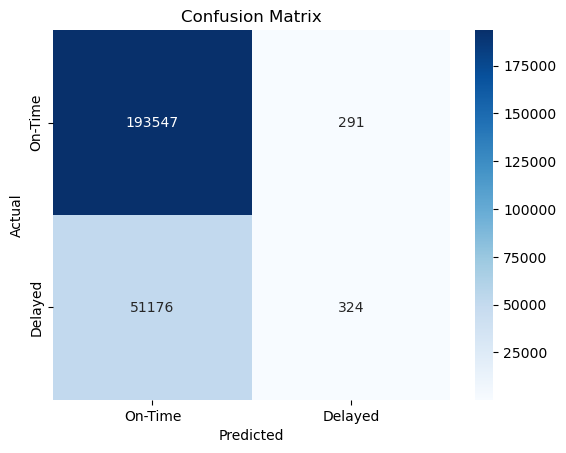

In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(test.iloc[:, 0], prediction_labels)

In [ ]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test.iloc[:, 0], prediction_labels))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.53      0.01      0.01     51500

    accuracy                           0.79    245338
   macro avg       0.66      0.50      0.45    245338
weighted avg       0.74      0.79      0.70    245338



### Observations and Insights


## Model 2 - Ensemble Model

---


### Loading Data


In [ ]:
df_ensemble = data_v1.copy()

df_ensemble.shape

(1635590, 75)

In [ ]:
df_ensemble.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_ensemble_cleaned = df_ensemble.replace({True: 1, False: 0})

df_ensemble_cleaned.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_ensemble_cleaned.isnull().sum().sum()

0

In [ ]:
df_ensemble_cleaned.shape

(1635590, 75)

### Train, Test and Validate Splits


In [ ]:
# split the data

train, test_and_validate = train_test_split(
    df_ensemble_cleaned,
    test_size=0.3,
    random_state=42,
    stratify=df_ensemble_cleaned["target"],
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [ ]:
# shape of train data
train.shape

(1144913, 75)

In [ ]:
# shape of test
test.shape

(245338, 75)

In [ ]:
# shape of validate
validate.shape

(245339, 75)

### Uploading Data to AWS S3 Buckets


In [ ]:
# set the names of the csv files
train_file = "data_v1E_train.csv"
test_file = "data_v1E_test.csv"
validate_file = "data_v1E_validate.csv"

In [ ]:
# uploading data to aws s3

upload_s3_csv(train_file, "train", train)
upload_s3_csv(test_file, "test", test)
upload_s3_csv(validate_file, "validate", validate)

s3.Bucket(name='u3253992-ajulthomas-oncloud')
s3.Bucket(name='u3253992-ajulthomas-oncloud')
s3.Bucket(name='u3253992-ajulthomas-oncloud')


### Retrieving the ML model - `xgboost`


In [ ]:
import boto3
from sagemaker.image_uris import retrieve

container = retrieve("xgboost", "us-east-1", version="1.0-1")

In [ ]:
hyperparams = {"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

In [ ]:
import sagemaker

# Ensure your session is set to the same region as the bucket
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=session,
)

In [ ]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(bucket, prefix, train_file), content_type="text/csv"
)

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(bucket, prefix, validate_file),
    content_type="text/csv",
)

print(f"channels {validate_channel} \n {train_channel}")

data_channels = {"train": train_channel, "validation": validate_channel}

channels <sagemaker.inputs.TrainingInput object at 0x7fb07705ffa0> 


### Training the model


In [ ]:
xgb_model.fit(inputs=data_channels, logs=False)


2024-11-03 04:56:27 Starting - Starting the training job.
2024-11-03 04:56:40 Starting - Preparing the instances for training....
2024-11-03 04:57:07 Downloading - Downloading input data....
2024-11-03 04:57:33 Downloading - Downloading the training image...
2024-11-03 04:57:54 Training - Training image download completed. Training in progress..........
2024-11-03 04:58:44 Uploading - Uploading generated training model.
2024-11-03 04:58:57 Completed - Training job completed


### Deploying the model


In [ ]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.2xlarge",
)

-----!

### Creating batch input for predictions


In [ ]:
# extracts the features from the test data
batch_X = test.iloc[:, 1:]

# replace all True, False Values with 1 and 0
# batch_X = batch_X.replace({True: 1, False: 0})

# filename of the batch input file while uploading to s3
batch_X_file = "batch-in.csv"

# save the batch input file
upload_s3_csv(batch_X_file, "batch-in", batch_X)

s3.Bucket(name='u3253992-ajulthomas-oncloud')


In [ ]:
batch_X.isnull().sum().sum()

batch_X.shape

(245338, 74)

### Setting up batch transformation job


In [ ]:
# set the output location for the batch output
batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)

# set the batch input location
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)

# create the transformer object from the xgb model
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

### Batch Transform


In [ ]:
# starts the batch transform job
xgb_transformer.transform(
    data=batch_input, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

# waits for the batch transform job to finish
xgb_transformer.wait()

.........................2024-11-03T05:06:47.935:[sagemaker logs]: MaxConcurrentTransforms=8, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    

### Retrieving Prediction Results


In [ ]:
# initialize the s3 client
s3 = boto3.client("s3")

# get the batch output file generated by the batch transform job
obj = s3.get_object(
    Bucket=bucket, Key="{}/batch-out/{}".format(prefix, "batch-in.csv.out")
)

# read the batch output file
target_predicted = pd.read_csv(io.BytesIO(obj["Body"].read()), names=["class"])

### Exploring results


In [ ]:
# functoin to convert the predicted values to binary
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0


# convert the predicted values to binary
target_predicted_binary = target_predicted["class"].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
470151,0.0,1947.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
985696,0.0,925.0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
394886,0.0,862.0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
924542,0.0,1744.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1533313,0.0,936.0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
# extract the test labels
test_labels = test.iloc[:, 0]

test_labels.head(5)

470151     0.0
985696     0.0
394886     0.0
924542     0.0
1533313    0.0
Name: target, dtype: float64

### Results


#### Classification Report


In [ ]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test_labels, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85    193838
         1.0       0.40      0.30      0.34     51500

    accuracy                           0.76    245338
   macro avg       0.61      0.59      0.60    245338
weighted avg       0.74      0.76      0.75    245338



#### Confusion Matrix


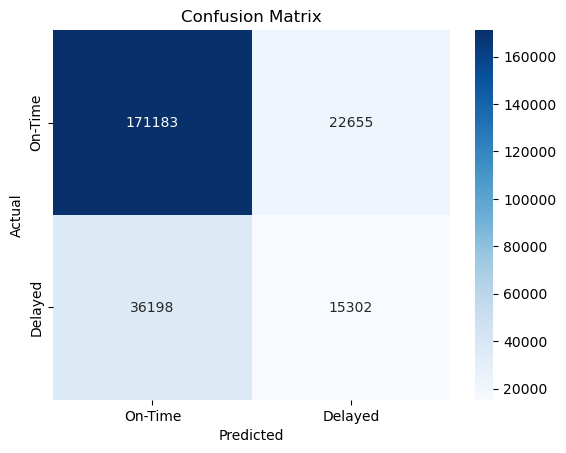

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(test_labels, target_predicted_binary)

In [ ]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 171183
False Positive (FP): 22655
False Negative (FN): 36198
True Positive (TP) : 15302


#### Sensitivity

_Sensitivity_ is also known as _hit rate_, _recall_, or _true positive rate (TPR)_. It measures the proportion of the actual positives that are correctly identified.


In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity = float(TP) / (TP + FN) * 100
print(f"Sensitivity or TPR: {Sensitivity}%")
print(
    f"There is a {Sensitivity}% chance of detecting detecting flights delayed are actually delayed."
)

Sensitivity or TPR: 29.712621359223302%
There is a 29.712621359223302% chance of detecting detecting flights delayed are actually delayed.


#### Specificity


In [ ]:
# Specificity or true negative rate
Specificity = float(TN) / (TN + FP) * 100
print(f"Specificity or TNR: {Specificity}%")
print(f"There is a {Specificity}% chance of .flights on-time are actually on-time")

Specificity or TNR: 88.31240520434591%
There is a 88.31240520434591% chance of .flights on-time are actually on-time


#### Overall Accuracy


In [ ]:
# Overall accuracy
ACC = float(TP + TN) / (TP + FP + FN + TN) * 100
print(f"Accuracy: {ACC}%")

Accuracy: 76.01146173849955%


#### AUC-ROC Curve


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

print("Validation AUC", roc_auc_score(test_labels, target_predicted))

Validation AUC 0.6730352404174559


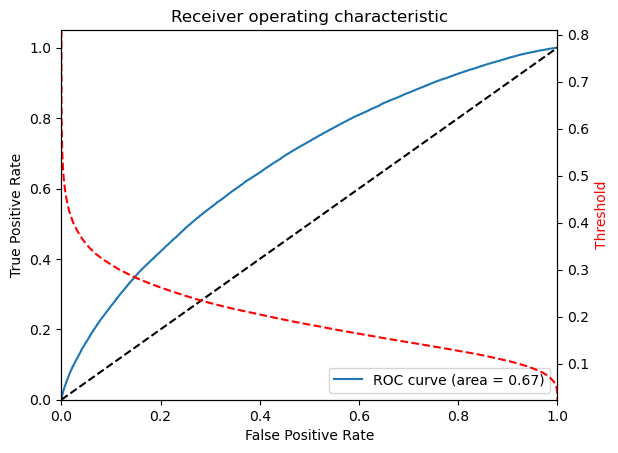

In [ ]:
import numpy as np

fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)

finite_indices = np.isfinite(thresholds)
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(
    fpr_finite,
    tpr_finite,
    label="ROC curve (area = %0.2f)" % auc(fpr_finite, tpr_finite),
)
plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(
        fpr_finite,
        thresholds_finite,
        markeredgecolor="r",
        linestyle="dashed",
        color="r",
    )
    ax2.set_ylabel("Threshold", color="r")
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()

# Machine Learning on AWS Cloud

## Combined Data version 2


In [ ]:
# import libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Setting up S3 bucket


In [ ]:
import logging


# import boto3


from botocore.exceptions import ClientError


def create_bucket(bucket_name, region=None):
    # Create an S3 bucket in a specified region
    # If a region is not specified, the bucket is created in the S3 default
    # region (us-east-1).
    # :param bucket_name: Bucket to create
    # :param region: String region to create bucket in, e.g., 'us-west-2'
    # :return: True if bucket created, else False

    # Create bucket

    try:

        if region is None:

            s3_client = boto3.client("s3")

            s3_client.create_bucket(Bucket=bucket_name)
        else:

            s3_client = boto3.client("s3", region_name=region)

            location = {"LocationConstraint": region}

            s3_client.create_bucket(
                Bucket=bucket_name, CreateBucketConfiguration=location
            )

    except ClientError as e:

        logging.error(e)

        return False

    print(f"S3 Bucket: {bucket_name} created successfully")

    return True

In [ ]:
# Function to check if the bucket exists
def check_bucket_exists(bucket_name):
    s3 = boto3.client("s3")
    try:
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        # If a 404 error is raised, the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            # If there's any other error, raise it
            raise

In [ ]:
# set the s3 bucket name
bucket = "u3253992-ajulthomas-oncloud"

# fetch the s3 resource
s3_resource = boto3.Session().resource("s3")


# check if bucket exists
bucket_exists = check_bucket_exists(bucket)

# Create the bucket if it doesn't exist
if not bucket_exists:
    create_bucket(bucket)

Bucket 'u3253992-ajulthomas-oncloud' already exists.


In [ ]:
# setting the prefix
prefix = "oncloud2"


# uploading data to aws s3
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_resource.Bucket(bucket))
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

### Generic Functions


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# function to plot confusion matrix
def plot_confusion_matrix(test_labels, target_predicted):
    # complete the code here
    cm = confusion_matrix(test_labels, target_predicted)
    # Create a heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["On-Time", "Delayed"],
        yticklabels=["On-Time", "Delayed"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Matplotlib is building the font cache; this may take a moment.


### Loading Data


In [ ]:
import pandas as pd

# load the data


data_v2 = pd.read_csv("./combined_csv_v2.csv")


data_v2.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# shape of the data
data_v2.shape

(1635590, 86)

## Model 1 - Linear Learner

---


In [ ]:
# create a copt of the version 1 data

df = data_v2.copy()

df.shape

(1635590, 86)

In [ ]:
# df_cleaned = df.replace({True: 1, False: 0})

# df_cleaned.head(5)

In [ ]:
# df_cleaned.isnull().sum().sum()

In [ ]:
# df_cleaned.shape

In [ ]:
# split the data

train, test_and_validate = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [ ]:
# shape of train data
train.shape

(1144913, 86)

In [ ]:
# shape of test
test.shape

(245338, 86)

In [ ]:
# shape of validate
validate.shape

(245339, 86)

In [ ]:
# set the names of the csv files
train_file = "data_v2_train.csv"
test_file = "data_v2_test.csv"
validate_file = "data_v2_validate.csv"

### Upload data to S3 Bucket


In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac


# prepare data for sagemaker training


def prepare_data(dataframe):
    vectors = dataframe.drop(columns=["target"]).values.astype("float32")
    labels = dataframe["target"].values.astype("float32")
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, vectors, labels)
    buf.seek(0)

    return buf

In [ ]:
import boto3
import os


# upload training data to s3
def upload_s3_buf(buf, bucket, prefix, type):
    key = "recordio-pb-data"
    boto3.resource("s3").Bucket(bucket).Object(
        os.path.join(prefix, type, key)
    ).upload_fileobj(buf)
    s3_data_path = "s3://{}/{}/{}/{}".format(bucket, prefix, type, key)
    print("uploaded {} data to location: {}".format(type, s3_data_path))
    return s3_data_path

In [ ]:
# prepare train data
train_buf = prepare_data(train)

# upload train data
s3_train_data = upload_s3_buf(train_buf, bucket, prefix, "train")

uploaded train data to location: s3://u3253992-ajulthomas-oncloud/oncloud2/train/recordio-pb-data


In [ ]:
# prepare validation data
validate_buf = prepare_data(validate)

# upload validation data
s3_validate_data = upload_s3_buf(validate_buf, bucket, prefix, "validate")

uploaded validate data to location: s3://u3253992-ajulthomas-oncloud/oncloud2/validate/recordio-pb-data


In [ ]:
output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://u3253992-ajulthomas-oncloud/oncloud2/output


In [ ]:
from sagemaker.image_uris import retrieve

# container = retrieve("linear-learner", boto3.Session().region_name)
container = retrieve("linear-learner", "us-east-1")

### Training the model


In [ ]:
import boto3

# sess = sagemaker.Session()

# Ensure your session is set to the same region as the bucket
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

# Get the execution role
role = sagemaker.get_execution_role()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.c5.2xlarge",
    output_path=output_location,
    sagemaker_session=session,
)
linear.set_hyperparameters(feature_dim=85, predictor_type="binary_classifier")

linear.fit({"train": s3_train_data, "validation": s3_validate_data}, logs=False)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-03-03-45-21-975



2024-11-03 03:45:24 Starting - Starting the training job..
2024-11-03 03:45:40 Starting - Preparing the instances for training...
2024-11-03 03:46:01 Downloading - Downloading input data....
2024-11-03 03:46:26 Downloading - Downloading the training image........
2024-11-03 03:47:17 Training - Training image download completed. Training in progress.......................................................................
2024-11-03 03:53:28 Uploading - Uploading generated training model
2024-11-03 03:53:36 Completed - Training job completed


### Create transformers and making predictions


In [ ]:
import boto3
import pandas as pd
import io

# Prepare the input data for batch prediction
batch_X_linear = test.iloc[:, 1:]
batch_X_file_linear = "batch-in-linear.csv"

# Upload the CSV to S3
upload_s3_csv(batch_X_file_linear, "batch-in-linear", batch_X_linear)

# Define the S3 paths
batch_output = "s3://{}/{}/batch-out-linear/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in-linear/{}".format(
    bucket, prefix, batch_X_file_linear
)

s3.Bucket(name='u3253992-ajulthomas-oncloud')


In [ ]:
# Create the transformer for the Linear Learner model
linear_transformer = linear.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

# Start the batch transform job
linear_transformer.transform(
    data=batch_input,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line",
    logs=False,
)

linear_transformer.wait()

INFO:sagemaker:Creating model with name: linear-learner-2024-11-03-03-55-16-209
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-03-03-55-17-793


........................................................................!
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 04:01:32 INFO 139856703743808] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 04:01:32 INFO 139856703743808] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib

#### Fetching and parsing predictions


In [ ]:
# Fetch and read the output from S3
s3 = boto3.client("s3")
obj = s3.get_object(
    Bucket=bucket,
    Key="{}/batch-out-linear/{}".format(prefix, "batch-in-linear.csv.out"),
)
target_predicted = pd.read_csv(
    io.BytesIO(obj["Body"].read()), header=None, names=["class"]
)

# Print or further process the predictions
target_predicted.head(5)

,class
"{""predicted_label"":0",score:0.092295482754707}
"{""predicted_label"":0",score:0.150472730398178}
"{""predicted_label"":0",score:0.09202516824007}
"{""predicted_label"":0",score:0.127865061163902}
"{""predicted_label"":0",score:0.150395348668098}


In [ ]:
predictions = target_predicted.index
predictions[0][-1]

'0'

In [ ]:
target_predicted.iloc[0, 0][6:-1]

'0.092295482754707'

In [ ]:
predictions = target_predicted.index
prediction_labels = [prediction[-1] for prediction in predictions]
# prediction_label

In [ ]:
prediction_scores = [row[0][6:-1] for row in target_predicted.itertuples(index=False)]
# prediction_scores

In [ ]:
import pandas as pd

# Convert prediction_scores and prediction_labels to numeric
prediction_scores = pd.to_numeric(prediction_scores)
prediction_labels = pd.to_numeric(prediction_labels)

In [ ]:
len(prediction_scores)

245338

In [ ]:
len(prediction_labels)

245338

### Results


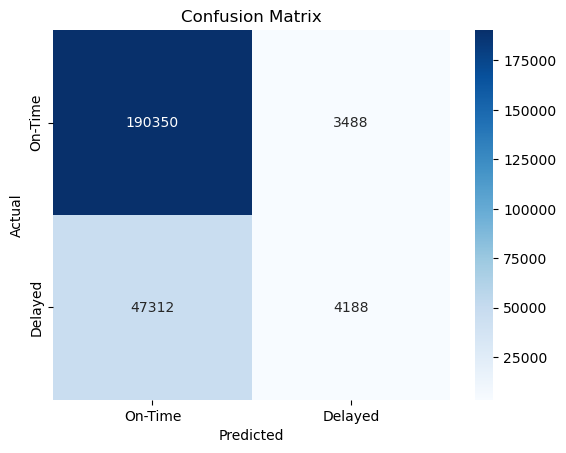

In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(test.iloc[:, 0], prediction_labels)

In [ ]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test.iloc[:, 0], prediction_labels))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88    193838
         1.0       0.55      0.08      0.14     51500

    accuracy                           0.79    245338
   macro avg       0.67      0.53      0.51    245338
weighted avg       0.75      0.79      0.73    245338



### Observations and Insights


## Model 2 - Ensemble Model

---


### Loading Data


In [ ]:
df_ensemble = data_v2.copy()

df_ensemble.shape

(1635590, 86)

In [ ]:
df_ensemble.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_ensemble_cleaned = df_ensemble.replace({True: 1, False: 0})

df_ensemble_cleaned.head(5)

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_ensemble_cleaned.isnull().sum().sum()

0

In [ ]:
df_ensemble_cleaned.shape

(1635590, 86)

### Train, Test and Validate Splits


In [ ]:
# split the data

train, test_and_validate = train_test_split(
    df_ensemble_cleaned,
    test_size=0.3,
    random_state=42,
    stratify=df_ensemble_cleaned["target"],
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [ ]:
# shape of train data
train.shape

(1144913, 86)

In [ ]:
# shape of test
test.shape

(245338, 86)

In [ ]:
# shape of validate
validate.shape

(245339, 86)

### Uploading Data to AWS S3 Buckets


In [ ]:
# set the names of the csv files
train_file = "data_v2E_train.csv"
test_file = "data_v2E_test.csv"
validate_file = "data_v2E_validate.csv"

In [ ]:
# uploading data to aws s3

upload_s3_csv(train_file, "train", train)
upload_s3_csv(test_file, "test", test)
upload_s3_csv(validate_file, "validate", validate)

s3.Bucket(name='u3253992-ajulthomas-oncloud')
s3.Bucket(name='u3253992-ajulthomas-oncloud')
s3.Bucket(name='u3253992-ajulthomas-oncloud')


### Retrieving the ML model - `xgboost`


In [ ]:
import boto3
from sagemaker.image_uris import retrieve

container = retrieve("xgboost", "us-east-1", version="1.0-1")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [ ]:
hyperparams = {"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

In [ ]:
import sagemaker

# Ensure your session is set to the same region as the bucket
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=session,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [ ]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(bucket, prefix, train_file), content_type="text/csv"
)

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(bucket, prefix, validate_file),
    content_type="text/csv",
)

print(f"channels {validate_channel} \n {train_channel}")

data_channels = {"train": train_channel, "validation": validate_channel}

channels <sagemaker.inputs.TrainingInput object at 0x7f901b2a5900> 


### Training the model


In [ ]:
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-03-04-04-31-407



2024-11-03 04:04:33 Starting - Starting the training job.
2024-11-03 04:04:47 Starting - Preparing the instances for training....
2024-11-03 04:05:11 Downloading - Downloading input data....
2024-11-03 04:05:36 Downloading - Downloading the training image...
2024-11-03 04:05:57 Training - Training image download completed. Training in progress............
2024-11-03 04:07:00 Uploading - Uploading generated training model
2024-11-03 04:07:08 Completed - Training job completed


### Deploying the model


In [ ]:
# xgb_predictor = xgb_model.deploy(
#     initial_instance_count=1,
#     serializer=sagemaker.serializers.CSVSerializer(),
#     instance_type="ml.c5.2xlarge",
# )

### Creating batch input for predictions


In [ ]:
# extracts the features from the test data
batch_X = test.iloc[:, 1:]

# replace all True, False Values with 1 and 0
# batch_X = batch_X.replace({True: 1, False: 0})

# filename of the batch input file while uploading to s3
batch_X_file = "batch-in.csv"

# save the batch input file
upload_s3_csv(batch_X_file, "batch-in", batch_X)

s3.Bucket(name='u3253992-ajulthomas-oncloud')


In [ ]:
batch_X.isnull().sum().sum()

batch_X.shape

(245338, 85)

In [ ]:
batch_X.head()

,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
470151,1947.0,13,30,0,158.0,22,0,244.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
985696,925.0,14,50,0,212.0,33,0,109.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
394886,862.0,9,31,0,24.0,45,0,-58.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
924542,1744.0,10,41,0,229.0,34,0,194.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
1533313,936.0,7,20,43,257.0,52,0,301.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


### Setting up batch transformation job


In [ ]:
# set the output location for the batch output
batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)

# set the batch input location
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)

# create the transformer object from the xgb model
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-04-08-21-409


### Batch Transform


In [ ]:
# starts the batch transform job
xgb_transformer.transform(
    data=batch_input, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

# waits for the batch transform job to finish
xgb_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-03-04-08-54-513


..............................[2024-11-03:04:14:22:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:04:14:22:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:04:14:22:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-03 04:14:22 +0000] [27] [INFO] Starting gunic

### Retrieving Prediction Results


In [ ]:
# initialize the s3 client
s3 = boto3.client("s3")

# get the batch output file generated by the batch transform job
obj = s3.get_object(
    Bucket=bucket, Key="{}/batch-out/{}".format(prefix, "batch-in.csv.out")
)

# read the batch output file
target_predicted = pd.read_csv(io.BytesIO(obj["Body"].read()), names=["class"])

### Exploring results


In [ ]:
# functoin to convert the predicted values to binary
def binary_convert(x):
    threshold = 0.28
    if x > threshold:
        return 1
    else:
        return 0


# convert the predicted values to binary
target_predicted_binary = target_predicted["class"].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
470151,0.0,1947.0,13,30,0,158.0,22,0,244.0,0.0,...,0,0,0,0,0,0,0,0,0,0
985696,0.0,925.0,14,50,0,212.0,33,0,109.0,0.0,...,0,0,0,0,0,0,1,0,0,0
394886,0.0,862.0,9,31,0,24.0,45,0,-58.0,0.0,...,0,0,1,0,0,0,0,0,0,0
924542,0.0,1744.0,10,41,0,229.0,34,0,194.0,0.0,...,0,0,0,0,0,1,0,0,0,1
1533313,0.0,936.0,7,20,43,257.0,52,0,301.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# extract the test labels
test_labels = test.iloc[:, 0]

test_labels.head(5)

470151     0.0
985696     0.0
394886     0.0
924542     0.0
1533313    0.0
Name: target, dtype: float64

### Results


#### Classification Report


In [ ]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test_labels, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85    193838
         1.0       0.44      0.47      0.45     51500

    accuracy                           0.76    245338
   macro avg       0.65      0.65      0.65    245338
weighted avg       0.77      0.76      0.76    245338



#### Confusion Matrix


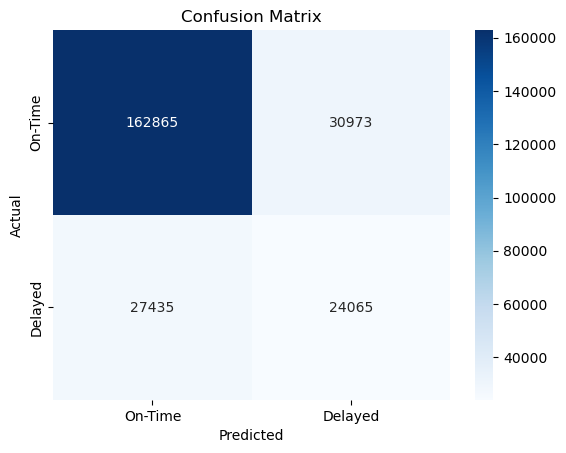

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(test_labels, target_predicted_binary)

In [ ]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 162865
False Positive (FP): 30973
False Negative (FN): 27435
True Positive (TP) : 24065


#### Sensitivity

_Sensitivity_ is also known as _hit rate_, _recall_, or _true positive rate (TPR)_. It measures the proportion of the actual positives that are correctly identified.


In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity = float(TP) / (TP + FN) * 100
print(f"Sensitivity or TPR: {Sensitivity}%")
print(
    f"There is a {Sensitivity}% chance of detecting detecting flights delayed are actually delayed."
)

Sensitivity or TPR: 46.728155339805824%
There is a 46.728155339805824% chance of detecting detecting flights delayed are actually delayed.


#### Specificity


In [ ]:
# Specificity or true negative rate
Specificity = float(TN) / (TN + FP) * 100
print(f"Specificity or TNR: {Specificity}%")
print(f"There is a {Specificity}% chance of flights on-time are actually on-time")

Specificity or TNR: 84.02119295494175%
There is a 84.02119295494175% chance of flights on-time are actually on-time


#### Overall Accuracy


In [ ]:
# Overall accuracy
ACC = float(TP + TN) / (TP + FP + FN + TN) * 100
print(f"Accuracy: {ACC}%")

Accuracy: 76.19284415785569%


#### AUC-ROC Curve


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

print("Validation AUC", roc_auc_score(test_labels, target_predicted))

Validation AUC 0.7314451676041759


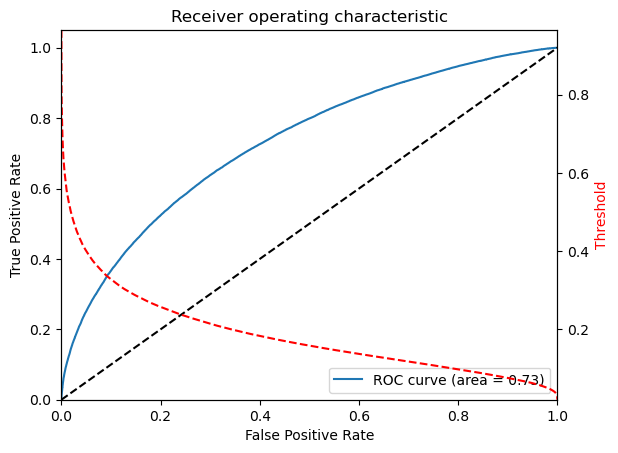

In [ ]:
import numpy as np

fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)

finite_indices = np.isfinite(thresholds)
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(
    fpr_finite,
    tpr_finite,
    label="ROC curve (area = %0.2f)" % auc(fpr_finite, tpr_finite),
)
plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(
        fpr_finite,
        thresholds_finite,
        markeredgecolor="r",
        linestyle="dashed",
        color="r",
    )
    ax2.set_ylabel("Threshold", color="r")
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:

1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance
6. write down your observation on the difference between the performance of using the simple and ensemble models.
   Note: You are required to perform the above steps on the two combined datasets separatey.


**Note** Ensemble and Linear codes above. The tasks have been performed togethor for the same dataset, due to aws time constraints.


In [4]:
# Write the code here and add cells as you need

**Observations and Conclusion**

The on-premise results, generated using a logistic regression model, showed significant challenges in identifying delayed flights (minority class). Both iterations of the cloud-based modeling improved upon this but displayed varying degrees of success.

In the first cloud iteration (version 1 of the dataset), the Linear Learner model struggled to detect delayed flights effectively, similar to the on-premise model, as indicated by low recall and F1-scores for the minority class. The XGBoost ensemble model, however, provided better precision and recall for delayed flights compared to the Linear Learner, reflecting its enhanced capability to capture complex patterns.

The second iteration (version 2 of the dataset with additional features) led to more noticeable improvements. The Linear Learner model showed a slight boost in performance but still had low recall for the delayed flights, while the XGBoost model continued to outperform the simpler models with higher precision and recall for the minority class. This demonstrates that ensemble models, particularly XGBoost, were more effective in handling the imbalanced dataset and leveraging the additional weather-related features to improve prediction accuracy.

It's essential to highlight that the dataset was heavily imbalanced, with delayed flights being the minority class, which posed challenges for all models, especially in recall for the delayed flight predictions.
